In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Normal Prior, LogNormal Likelihood - Mean and Covariance Unknown

The LogNormal($\theta$) with $ \theta = (\mu, \sigma^2)$ is reparametrized according to the exponential family's natural parameters:

$ \eta(\theta) = \eta(\mu, \sigma^2) = (\mu / \sigma^2, -1 / 2\sigma^2) = (\eta_1, \eta_2) $

$ \eta^{-1}(\eta_1, \eta_2) = (-\eta_1 / 2\eta_2, -1 / 2\eta_2)$

Therefore, the prior is on $\eta$ and of the form

$ \pi (\eta; \alpha, R) \propto \exp \left(-\frac{1}{2}(\eta - \alpha)^T R^{-1}(\eta - \alpha)   \right) $,

where we need to specify $\alpha$ and $R$, the prior mean and prior covariance (mean on $\eta$, not $\theta$!).

In [2]:
#useful functions

def eta(mu, sigma2):
    """computes eta(theta) = eta(mu, sigma2)"""
    return np.array([[mu/sigma2, -1/(2*sigma2)]]).T

def eta_inv(eta1, eta2):
    """recovers mu, sigma^2 (**NOT** sigma only, its square)"""
    return np.array([-eta1/(2*eta2), -1/(2*eta2) ])

def eta_inv_jac(eta1, eta2):
    """compute the jacobian of eta^{-1}(eta1, eta2)"""
    return np.array([ [-1/(2*eta2), eta1/(2*eta2**2)],
                        [0.         , 1/(2*eta2**2)] ]
                    )

def log_normal_density(x, mu, sigma2):
    return 1 / np.sqrt(x**2 * sigma2 * 2 * np.pi) * np.exp( (-1/2) * (np.log(x) - mu)**2 / sigma2 )

def normal_density(x, mu, sigma2):
    return 1 / np.sqrt(sigma2 * 2 * np.pi) * np.exp( (-1/2) * (x - mu)**2 / sigma2 )

def MV_normal(x, mu, Sigma):
    return np.exp((-1/2) * (x - mu).T @ np.linalg.inv(Sigma) @ (x - mu))

In [3]:
#Class computing the posterior of \eta(\theta) given observations

class LogNormal():
    def __init__(self, eta_prior_mean, eta_prior_cov):
        self.eta_prior_mean = eta_prior_mean #prior on eta
        self.eta_prior_cov = eta_prior_cov #prior on cov of eta
        self.num_params = eta_prior_mean.size

        self.dr_ = lambda x : np.array([[1 / x, 2 * np.log(x) / x]])
        self.db_ = lambda x : -1/x

        self.ddr_ = lambda x : np.array([[-1 / x**2, (2 - 2*np.log(x)) / x**2]])
        return
    
    def posterior(self, data):
        assert data.ndim == 1, "Data must be 1-dimensional"

        Lambda = np.zeros((self.num_params, self.num_params), dtype=float)
        Nu = np.zeros(self.eta_prior_mean.shape)

        T = len(data)

        for x in data:
            Lambda += (1/T) * self.dr_(x).T @ self.dr_(x)
            Nu += (2/T) * (self.dr_(x).T * self.db_(x) + self.ddr_(x).T)

        eta_post_cov = np.linalg.inv(np.linalg.inv(self.eta_prior_cov) + 2 * T * Lambda)
        eta_post_mean = eta_post_cov @ (np.linalg.inv(self.eta_prior_cov) @ self.eta_prior_mean - T * Nu)

        return eta_post_mean.flatten(), eta_post_cov

### Create the Data

In [4]:
#fix a random seed for experimental purposes
np.random.seed(0)

#the "true parameters", and the generated data
mu = 1.0
sigma2 = 0.4**2

size = 1000
data = np.random.lognormal(mean=mu, sigma=np.sqrt(sigma2), size=size)

### Establish Prior and Compute Posterior

In [5]:
#Setting the prior on theta = (mu, sigma2)
mu_prior, sigma2_prior = 0.5, 1.0
theta_prior_mean = np.array([mu_prior, sigma2_prior])

#converting the prior mu and sigma2 to natural parameters
eta_prior_mean = eta(*theta_prior_mean)
eta_prior_cov = np.eye(2)

#instantiating the LogNormal class and obtaining the posterior mean and covariance for the r.v. \eta | data 
lognorm = LogNormal(eta_prior_mean=eta_prior_mean, eta_prior_cov=eta_prior_cov)
eta_post_mean, eta_post_cov = lognorm.posterior(data=data)

#converting back from eta to mu, sigma2, and obtaining the mean and covariance for mu and sigma2
theta_post_mean = eta_inv(*eta_post_mean)
theta_post_cov = eta_inv_jac(*eta_post_mean) @ eta_post_cov @ eta_inv_jac(*eta_post_mean).T

### Plotting the Posterior

Text(0.5, 0.5, 'sigma2')

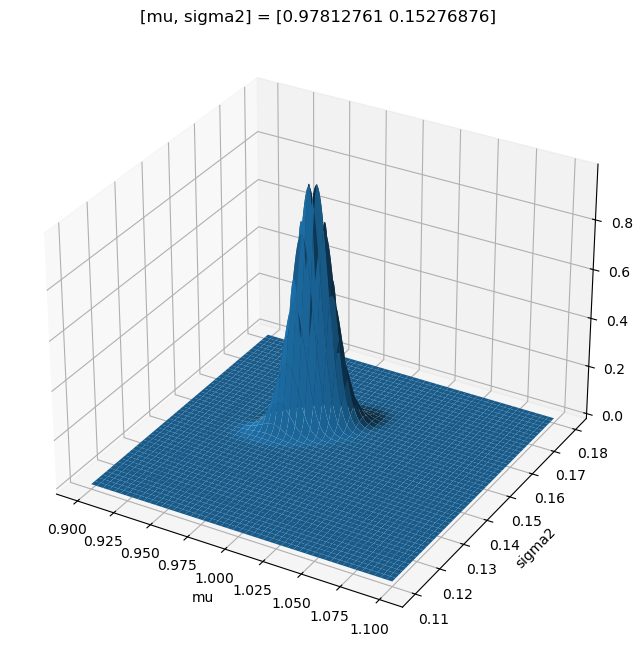

In [6]:
fig = plt.figure(figsize = (10,8))
 
mu_range = np.linspace(0.9, 1.1, 500)
sigma2_range = np.linspace(0.11, 0.18, 500)

Z = np.array([[MV_normal(np.array([x, y]), theta_post_mean, theta_post_cov) for x in mu_range] for y in sigma2_range])

X, Y = np.meshgrid(mu_range, sigma2_range)

ax = plt.axes(projection='3d')
 
# syntax for plotting
ax.plot_surface(X, Y, Z)
_=plt.title("[mu, sigma2] = {}".format(theta_post_mean))
plt.xlabel("mu")
plt.ylabel("sigma2")

### Comparison with Normal-Normal likelihood (known variance)


In [10]:

NN_sigma2 = data.var() #Normal-Normal likelihood covariance (known)
NN_theta_post = (1 / (1/sigma2_prior + size/NN_sigma2) ) * (mu_prior/sigma2_prior + data.sum()/NN_sigma2)


print("naive estimate (mean, var) : ", data.mean(), data.var())
print("theta (Normal-Normal) : ", np.array([NN_theta_post, NN_sigma2]))
print("theta (Normal-LogNormal) : ", theta_post_mean)
print("theta (true) : ", np.array([mu, sigma2]))

Naive estimate (mean, var) :  2.8866776763282203 1.4097891327891974
theta (Normal-Normal) :  [2.8833177  1.40978913]
theta (Normal-LogNormal) :  [0.97812761 0.15276876]
theta (true) :  [1.   0.16]
